# Quora Questions

Here I'll be playing around with the Quora Questions dataset from Kaggle.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn; seaborn.set()

In [3]:
q_data = pd.read_csv(folder + 'train.csv')

In [4]:
q_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Lets take some time to properly define the meaning of each field.

- `id` - the id of a training set question pair
- `qid1`, `qid2` - unique ids of each question (only available in train.csv)
- `question1`, `question2` - the full text of each question
- `is_duplicate` - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

So `id`, `qid1`, `qid2` are just identification variables, and so don't actually have any useful information content.

Now lets take a look at some of the data.

In [5]:
len(q_data)

404290

The data has 400,000+ rows, which should be enough to do some interesting things, but how many unique questions are there really?

In [6]:
len(np.unique(q_data.qid1)), len(np.unique(q_data.qid1))

(290654, 290654)

So only around 300,000 unique questions, which is actually a higher proportion of the training data than I might have expected.

Next question is - what is the proportion of matches to non-matches?

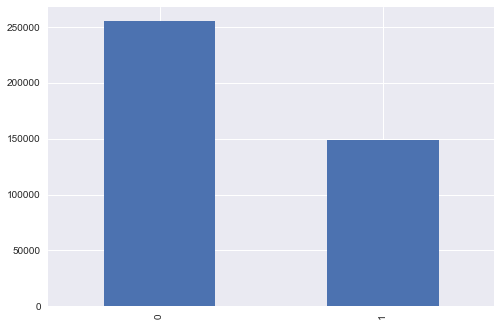

In [7]:
q_data.is_duplicate.value_counts().plot(kind='bar')

The next thing I'd like to visualise is how the questions are all related to one another. Considering that there are questions that appear in multiple duplicate pairs, how are these connected to one another? I can do this by creating an adjacency matrix.

In [9]:
num_qs = len(np.unique(np.concatenate([q_data.qid1, q_data.qid2])))
adj_matx = np.ones(shape=(num_qs, num_qs))

MemoryError: 

Or.. rather I would make an adjacency matrix if it would fit into memory.

In [10]:
print(num_qs ** 2)

289371912489


That's 289 billion unique values in this single object. Hence it won't fit into memory.

But I'm not one to give up so easily, so how about I encode this as a sparse matrix?

In [11]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='white')
    ax.plot(m.row[m.data == 1], m.col[m.data == 1], 's', color='blue', ms=0.15)
    ax.plot(m.row[m.data == 0], m.col[m.data == 0], 's', color='red', ms=0.15)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    #ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


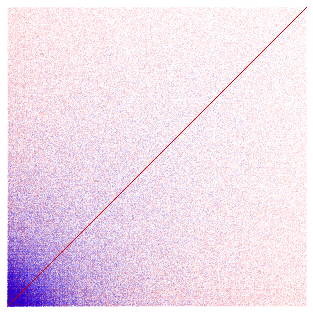

In [13]:
import numpy as np
from scipy.sparse import coo_matrix

shape = (num_qs + 1, num_qs + 1)
rows = np.concatenate([np.int_(q_data.qid1),
                       np.int_(q_data.qid2),
                       np.arange(num_qs + 1)
                      ])
cols = np.concatenate([np.int_(q_data.qid2), 
                       np.int_(q_data.qid1),
                       np.arange(num_qs + 1)
                      ])
vals = np.concatenate([np.int_(q_data.is_duplicate),
                       np.int_(q_data.is_duplicate),
                       np.ones(num_qs + 1)
                      ])

m = coo_matrix((vals, (rows, cols)), shape=shape)
ax = plot_coo_matrix(m)
ax.figure.show()

Later, I can try representing this graph in a graph database.

# Analysing the Text

Now, lets take a shot at actually processing the text information. Lets look from the perspective of asking which questions are the most common etc.

In [14]:
qs = np.concatenate([q_data.question1, q_data.question2])
qs = set([str(q) for q in qs])
qs = sorted(qs)

In [15]:
qs[:5]

[' Any Canadian teachers (B.Ed. holders) teaching in U.S. schools?',
 ' Are there any underlying psychological tricks/tactics that are used when designing the lines for rides at amusement parks?',
 ' Can I pay with a debit card on PayPal?',
 ' Does New York state have a flagship university?',
 ' Failures haunt me all the time.How do I cope up?']

In [16]:
len(qs)

537362

So there are 537,000 unique questions. Now lets take a look at which characters occur in the dataset?

In [17]:
import functools

In [18]:
chs = [set(q) for q in qs]
chs = sorted(functools.reduce(set.union, chs))

In [19]:
''.join(chs)

'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x7f\x80\x87\x8f\x93\x9d¢£¤¥§¨©«¬\xad®°±²³´µ·¹º»¼½¾¿ÀÁÄÅÉÌÎÒÓÖ×ØÜàáâãäåæçèéêëìíîïðñòóôö÷øùúûüāăąćēėęğĩīİıĹĺłńňŋōœŕŚśŞşŠšŧũūƒƕƫǎǐǔǡțɐɖəɜɡɪɮɽʉʊʌʛʻʾː̱́ΔΙΜΞΠΡΣΧΩάίαβγδεηθκλμνοπρςστυφχψόώϞϵАВГДКНСабвгдежзийклнопрстуфхцчщыьюяҿְִָֹאבדהויכםמנספקרשת؟ءأؤإابةتثجحخدذرزسشصضظعغـفقكلمنهوىيکیँंःअआइईउऊऋएऐऔकखगचजटठडणतथदधनपफबभमयरलवशषसहािीुूृेैो्ॐड़फ़।३६জডতনপযসহাি্ਬਰਸ਼ੇੱଁଇକଧରାିஅஆஇஎகஙசடணதநனபமயரறலளழவாிுெேைொோ்ంఅజణనమరవాిుూಕಗಟಣತದಬಭಮರವಸಾಿುೂೆ್ഏകചഛജടതധനമരറഴസാിേോ്ൺർൾกคงจชซตถทนบปพฟมยรลวสหอัาำิีืุเแโใไ่้์ཡងដផរែḵṛṭệịộởữἐἶ\u200b\u200c\u200e\u200f‑–—‖‘’“”•…\u202a\u202c′″⁄\u2060\u2061⁴₂₅€₹℃℅ℝ℞™→∀∂∃∅∆∈−∓∖√∝∞∠∧∨∩∪∫≈≜≠≡≤≥⊂⊃⊆⊇⋯⌈⌉⏰┬╥◾☉☐☺♎♥⚡⚪✂✊✢➡➰⺈、。「」〖〗〽あいうかがきくけこごさざしすずせそただっつづてでとどなにのはばひびふほまみもやよらるれをんイグシトフプポルンーㄴㅇㅋㅌㅐ㊗㊙㎡一丁三上下不与专世东个中主久么义之乐也买乾了事二亚些交亮人什仁今从他付令以们仰任份伐休会伝伤伯但位体何你使來例便信修做傷傻僕儿允先光兔入內公共关兴其内冉冒冷几出分刚初利别到制則功动動勿十南卡印即卷历厚去县又友反变口另叫可吃合吉名后吐向君吝吴员呵呼哥唱啦啪啬喃善喝嘚回国图土在地场坏型城壁夏外多夜夢大天太失奖女好如妈妙妮子字存孤学安宋客宪家寂寒寞对导封将小少尖尚就尼局居島州工左己市师師常帽干平年幸序度廉建开弱形往很律得循心必忍忘怀思性怪

In [20]:
non_eng_chs = ''.join(chs)[96:]

In [21]:
non_eng_chs

'\x7f\x80\x87\x8f\x93\x9d¢£¤¥§¨©«¬\xad®°±²³´µ·¹º»¼½¾¿ÀÁÄÅÉÌÎÒÓÖ×ØÜàáâãäåæçèéêëìíîïðñòóôö÷øùúûüāăąćēėęğĩīİıĹĺłńňŋōœŕŚśŞşŠšŧũūƒƕƫǎǐǔǡțɐɖəɜɡɪɮɽʉʊʌʛʻʾː̱́ΔΙΜΞΠΡΣΧΩάίαβγδεηθκλμνοπρςστυφχψόώϞϵАВГДКНСабвгдежзийклнопрстуфхцчщыьюяҿְִָֹאבדהויכםמנספקרשת؟ءأؤإابةتثجحخدذرزسشصضظعغـفقكلمنهوىيکیँंःअआइईउऊऋएऐऔकखगचजटठडणतथदधनपफबभमयरलवशषसहािीुूृेैो्ॐड़फ़।३६জডতনপযসহাি্ਬਰਸ਼ੇੱଁଇକଧରାିஅஆஇஎகஙசடணதநனபமயரறலளழவாிுெேைொோ்ంఅజణనమరవాిుూಕಗಟಣತದಬಭಮರವಸಾಿುೂೆ್ഏകചഛജടതധനമരറഴസാിേോ്ൺർൾกคงจชซตถทนบปพฟมยรลวสหอัาำิีืุเแโใไ่้์ཡងដផរែḵṛṭệịộởữἐἶ\u200b\u200c\u200e\u200f‑–—‖‘’“”•…\u202a\u202c′″⁄\u2060\u2061⁴₂₅€₹℃℅ℝ℞™→∀∂∃∅∆∈−∓∖√∝∞∠∧∨∩∪∫≈≜≠≡≤≥⊂⊃⊆⊇⋯⌈⌉⏰┬╥◾☉☐☺♎♥⚡⚪✂✊✢➡➰⺈、。「」〖〗〽あいうかがきくけこごさざしすずせそただっつづてでとどなにのはばひびふほまみもやよらるれをんイグシトフプポルンーㄴㅇㅋㅌㅐ㊗㊙㎡一丁三上下不与专世东个中主久么义之乐也买乾了事二亚些交亮人什仁今从他付令以们仰任份伐休会伝伤伯但位体何你使來例便信修做傷傻僕儿允先光兔入內公共关兴其内冉冒冷几出分刚初利别到制則功动動勿十南卡印即卷历厚去县又友反变口另叫可吃合吉名后吐向君吝吴员呵呼哥唱啦啪啬喃善喝嘚回国图土在地场坏型城壁夏外多夜夢大天太失奖女好如妈妙妮子字存孤学安宋客宪家寂寒寞对导封将小少尖尚就尼局居島州工左己市师師常帽干平年幸序度廉建开弱形往很律得循心必忍忘怀思性怪恋恬息悄情惊想愁意愛感懂戏成我战手才打扣抜押抽拍招持捕插搬摄撑支收改放政整文斯方族无日旮时昂明易星昧是晚晶智暧最月有朋朝未本术杂权杨杰杵果枯柳校核格栽桂森極槽横欺步武歪每毒比毕民气氣水汉沓没治法洞洲

Oh no, there are other languages in here. That is scary...

Why not take a look at the some of the non-english messages then?

In [22]:
import re

## Cleaning the Data

In order to make progress, I am going to remove the non-english characters in the process of cleaning the data. This seems like a sensible idea for now - and if it becomes evident that this is an issue later, then I will deal with it then.

In [32]:
import spacy

In [33]:
nlp = spacy.load('en')

In [34]:
# nlp_qs = [nlp(q) for q in qs]

There are quite a lot of questions in `qs`, so this takes quite a while to run. Thankfully spacy permits multithreading.

Spacy can also perform named entity recognition. This is performed when you make the `nlp` object for a given piece of text, and the result can be called via the attribute `.ents` for 'entities'.

In [40]:
q = nlp(qs[0])

In [42]:
q

 Any Canadian teachers (B.Ed. holders) teaching in U.S. schools?

In [43]:
q.ents

( Any Canadian, U.S.)

In [44]:
list(q.ents)

[ Any Canadian, U.S.]

It's not perfect (B.Ed. holders are also entities) but it's pretty good nonetheless.

Spacy can also distinguish parts of speech, which is great.

In [45]:
token_text = [token.orth_ for token in q]
token_pos = [token.pos_ for token in q]

pd.DataFrame(list(zip(token_text, token_pos)),
             columns=['token_text', 'part_of_speech'])

,token_text,part_of_speech
0,,SPACE
1,Any,DET
2,Canadian,ADJ
3,teachers,NOUN
4,(,PUNCT
5,B.Ed,PROPN
6,.,PUNCT
7,holders,NOUN
8,),PUNCT
9,teaching,NOUN


Spacy can also lemmatise and give the shape of each token.

In [46]:
token_lemma = [token.lemma_ for token in q]
token_shape = [token.shape_ for token in q]

pd.DataFrame(list(zip(token_text, token_lemma, token_shape)),
             columns=['token_text', 'token_lemma', 'token_shape'])

,token_text,token_lemma,token_shape
0,,,
1,Any,any,Xxx
2,Canadian,canadian,Xxxxx
3,teachers,teacher,xxxx
4,(,(,(
5,B.Ed,b.ed,X.Xx
6,.,.,.
7,holders,holder,xxxx
8,),),)
9,teaching,teaching,xxxx


Calculating summary statistics is also fairly straightforward.

In [48]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in q]

df = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

df.loc[:, 'stop?':'out of vocab.?'] = (df.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))
                                               
df

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,,-4.612954,,,Yes,,
1,Any,-9.606259,Yes,,,,
2,Canadian,-9.971039,,,,,
3,teachers,-10.422482,,,,,
4,(,-5.700670,,Yes,,,
5,B.Ed,-19.579313,,,,,Yes
6,.,-3.072948,,Yes,,,
7,holders,-19.579313,,,,,
8,),-5.341753,,Yes,,,
9,teaching,-10.515229,,,,,


There - so that is an interesting application of the models that I saw used on the Yelp dataset.

The usecase here is slightly different because each question is quite a small snippet of text. This means that analysing the frequency distribution in a particular question is less likely to be useful.

Now I'd quite like to attempt a tf-idf (Term Frequency - Inverse Document Frequency) analysis of a group of questions.

In [49]:
import random
random.seed(1234)

In [50]:
nlp_qs = [nlp(q) for q in random.sample(qs,1000)]

In [51]:
nlp_lemmas = [' '.join([token.lemma_ for token in q]) for q in nlp_qs]

In [52]:
ch_sets = [set(''.join(q)) for q in nlp_lemmas]
chs = functools.reduce(set.union, ch_sets)

In [53]:
print(''.join(chs))

0uൺbതa8 hशdr|qn-नz5é.k]vl√?[’്mN✊Pto27म9ാമ*ु:f)3e'"yRിw1&प4%,g6O;}c+‌s(गച$/രpxij{\


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
vectorizer = TfidfVectorizer(#stop_words='english'
                            ).fit(nlp_lemmas)

In [62]:
nlp_lemmas

['which domain be good for do cse final year project ?',
 'how do astronaut pee in zero gravity on the iss ?',
 'be there any bad/cruel starks in game of thrones ?',
 'how do -PRON- become a great role model for sibling ?',
 'do animal cell have cell membrane ? if so , how do -PRON- differ from the one in plant cell ?',
 'how can -PRON- simplify   [ math]\\frac{2+\\sqrt{3}}{\\sqrt{8 + 4\\sqrt{3}}}[/math ] ?',
 'how do -PRON- get vat/tin in gurgaon to sell online ?',
 'what be the good social medium organizer app ?',
 'should all theist ask question about atheism be advise to read -PRON- with theist instead of atheist in -PRON- first ?',
 'can -PRON- travel to mexico without a passport ?',
 'describe a morning where -PRON- have lose -PRON- sight and be force to find -PRON- way to work without -PRON- eyesight and everybody else be blind ?',
 'can -PRON- know the advantage and disadvantage of the metahuristic ?',
 'what be the darpu for yammer ?',
 'why do -PRON- have practical record in 

In [56]:
idf = vectorizer.idf_

In [57]:
tfidf_dict = dict(zip(vectorizer.get_feature_names(), idf))

In [58]:
tfidf_df = pd.DataFrame.from_dict(tfidf_dict,
                                 orient='index')

In [59]:
tfidf_df.sort_values(by=0, ascending=False)

,0
spirit,7.215608
annie,7.215608
url,7.215608
basically,7.215608
snap,7.215608
362,7.215608
children,7.215608
jagannath,7.215608
surround,7.215608
may,7.215608


Wow. This is totally not helpful.

I guess I have to be cleverer.

## Phrase Modelling

We will be bootstrapping from the talk titled `Modern NLP in Python`. Below is some code from the talk that we should be able to apply to our problem as well.

In [64]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [65]:
nlp_qs

[Which domain is best for doing CSE final year projects?,
 How do astronauts pee in zero gravity on the ISS?,
 Are there any bad/cruel Starks in Game of Thrones?,
 How do I become a great role model for siblings?,
 Do animal cells have cell membranes? If so, how does it differ from the one in plant cells?,
 How can you simplify  [math]\frac{2+\sqrt{3}}{\sqrt{8+4\sqrt{3}}}[/math]?,
 How do I get VAT/TIN in Gurgaon to sell online?,
 What is the best social media organizer app?,
 Should all theists asking questions about atheism be advised to read them with theist instead of atheist in them first?,
 Can I travel to Mexico without a passport?,
 Describe a morning where youve lost your sight and are forced to find your way to work without your eyesight and everybody else is blind?,
 Can I know the advantage and disadvantages of the metahuristics?,
 What is the DARPU for Yammer?,
 Why do we have practical records in engineering college?,
 Who will win the World Series?,
 How many minute will

In [66]:
def punct_or_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def unescape_breaks(q_list):
    """
    generator function to un-escape line breaks
    """
    for q in q_list:
        yield q.replace("\\n", '\n')
            
def lemmatized_sentence_corpus(q_list):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for nlp_q in nlp.pipe(unescape_breaks(q_list),
                                  batch_size=10000, n_threads=3):
        
        for sent in nlp_q.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_or_space(token)])

In [67]:
list(lemmatized_sentence_corpus(qs[:10]))

['any canadian teacher b.ed holder teaching in u.s. school',
 'be there any underlie psychological tricks/tactic that be use when design the line for ride at amusement park',
 'can -PRON- pay with a debit card on paypal',
 'do new york state have a flagship university',
 'failure haunt -PRON- all the time',
 'how do -PRON- cope up',
 'how can -PRON- improve -PRON- sex life',
 'how do -PRON- make the time lapse image use an eos 70d with an intervalometer',
 'how will -PRON- interpret -PRON- dream',
 "-PRON- be a 5 letter word -PRON- be normally below u if u remove -PRON- 1st letter u'll find -PRON- above u if u remove -PRON- 1st 2nd letter u can not see -PRON- answer be really very interesting let -PRON- see who solve this ⏰time limit today u can also send to oth grp if -PRON-",
 '-PRON- do not file a police report for a car accident that happen over a month ago',
 '-PRON- insurance company wo not pay for damage what do -PRON- do']

We have to lemmatize the text and then write it to disk. The model will read the data from the disk so that it never needs to be read directly into the RAM all at once.

In [68]:
intermediate_directory = 'intermediate//'
unigram_sentences_filepath = intermediate_directory + 'unigram_sentences_all.txt'

In [69]:
%%time
# with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
#     for sent in lemmatized_sentence_corpus(qs):
#         f.write(sent + '\n')

Wall time: 0 ns


Now that the file has been written to disk, we can feed it into `gensim`'s `LineSentence` model.

In [70]:
import itertools as it

In [71]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [72]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(' '.join(unigram_sentence))
    print('\n')

this be the message -PRON- be get when -PRON- be try to acces windows defender


what can -PRON- do


the camera produce blur picture what will be the aspect in this sentence where the entity be mobile -PRON- m ask in context of aspect level sa


the device be not ready problem encounter while initialize the external hard drive under disk management


be -PRON- hardware or software fault


the more thing change the more -PRON- stay the same -PRON- be not exactly clear what this phrase mean


can anyone help -PRON-


the question be mark as need improvement how to deal with this what ever -PRON- do still this error pop up


be -PRON- quora bot or any user


the reason why be because -PRON- hear that this be common usage for english speak people




Next, we'll learn a phrase model that will link individual words into two-word phrases. We'd expect words that together represent a specific concept, like "`ice cream`", to be linked together to form a new, single token: "`ice_cream`".

In [73]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [74]:
%%time
#bigram_model = Phrases(unigram_sentences)
#bigram_model.save(bigram_model_filepath)

Wall time: 0 ns


In [75]:
# load the finished model from disk
bigram_model = Phrases.load(bigram_model_filepath)

In [76]:
bigram_sentences_filepath = os.path.join(intermediate_directory,
                                         'bigram_sentences_all.txt')

In [77]:
%%time
# with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
#     for unigram_sentence in unigram_sentences:
#         bigram_sentence = u' '.join(bigram_model[unigram_sentence])
#         f.write(bigram_sentence + '\n')

Wall time: 0 ns


In [78]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [79]:
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print(' '.join(bigram_sentence))
    print('')

this be the message -PRON- be get when -PRON- be try to acces windows_defender

what can -PRON- do

the camera produce blur picture what will be the aspect in this sentence where the entity be mobile -PRON- m ask in context of aspect level sa

the device be not ready problem encounter while initialize the external_hard drive under disk management

be -PRON- hardware or software fault

the more thing change the more -PRON- stay the same -PRON- be not exactly clear what this phrase mean

can anyone_help -PRON-

the question be mark as need_improvement how to deal_with this what ever -PRON- do still this error pop_up

be -PRON- quora bot or any user

the reason why be because -PRON- hear that this be common usage for english_speak people



In [80]:
trigram_model_filepath = os.path.join(intermediate_directory,
                                      'trigram_model_all')

In [81]:
%%time

#trigram_model = Phrases(bigram_sentences)
#trigram_model.save(trigram_model_filepath)

Wall time: 0 ns


In [82]:
# load the finished model from disk
trigram_model = Phrases.load(trigram_model_filepath)

In [83]:
trigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'trigram_sentences_all.txt')

In [84]:
%%time
# with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
#     for bigram_sentence in bigram_sentences:
#         trigram_sentence = u' '.join(trigram_model[bigram_sentence])
#         f.write(trigram_sentence + '\n')

Wall time: 0 ns


In [85]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [64]:
for trigram_sentence in it.islice(trigram_sentences, 230, 240):
    print(' '.join(trigram_sentence))
    print('')

this be the message -PRON- be get when -PRON- be try to acces windows_defender

what can -PRON- do

the camera produce blur picture what will be the aspect in this_sentence where the entity be mobile -PRON- m ask in context of aspect level sa

the device be not ready problem encounter while initialize the external_hard_drive under disk management

be -PRON- hardware or software fault

the more thing change the more -PRON- stay the same -PRON- be not exactly clear what this phrase mean

can_anyone_help -PRON-

the question be mark as_need_improvement how to deal_with this what ever -PRON- do still this error pop_up

be -PRON- quora bot or any user

the reason why be because -PRON- hear that this be common usage for english_speak people



In [65]:
trigram_reviews_filepath = os.path.join(intermediate_directory,
                                        'trigram_transformed_reviews_all.txt')

In [66]:
review_txt_filepath = os.path.join(intermediate_directory,
                                   'review_text_all.txt')

In [68]:
import codecs

In [342]:
%%time

# with codecs.open(trigram_reviews_filepath, 'w', encoding='utf_8') as f:

#     for parsed_q in nlp.pipe(unescape_breaks(qs),
#                                   batch_size=10000, n_threads=4):

#         # lemmatize the text, removing punctuation and whitespace
#         unigram_qs = [token.lemma_ for token in parsed_q
#                           if not punct_space(token)]

#         # apply the first-order and second-order phrase models
#         bigram_qs = bigram_model[unigram_qs]
#         trigram_qs = trigram_model[bigram_qs]

#         # remove any remaining stopwords
#         trigram_qs = [term for term in trigram_qs
#                           if term not in spacy.en.STOP_WORDS]

#         # write the transformed review as a line in the new file
#         trigram_qs = u' '.join(trigram_qs)
#         f.write(trigram_qs + '\n')

C:\Program Files\Anaconda3\lib\site-packages\gensim\models\phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Wall time: 5min 39s


In [69]:
print('Original:' + u'\n')

for review in it.islice(qs, 11, 12):
    print(review)

print('----' + u'\n')
print('Transformed:' + u'\n')

with codecs.open(trigram_reviews_filepath, encoding='utf_8') as f:
    for review in it.islice(f, 11, 12):
        print(review)

Original:

 I'm openly gay and falling in love with my best friend I've known for 5 years he's a really great guy but I'm stuck. What should I do?
----

Transformed:

-PRON- openly_gay fall love -PRON- good friend -PRON- know 5_year -PRON- great guy -PRON- stuck -PRON-



# Latent Dirichlet Allocation

In [70]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

In [71]:
trigram_dictionary_filepath = os.path.join(intermediate_directory,
                                           'trigram_dict_all.dict')

In [ ]:
%%time

# trigram_qs = LineSentence(trigram_reviews_filepath)

# # learn the dictionary by iterating over all of the reviews
# trigram_dictionary = Dictionary(trigram_qs)

# # filter tokens that are very rare or too common from
# # the dictionary (filter_extremes) and reassign integer ids (compactify)
# trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
# trigram_dictionary.compactify()

# trigram_dictionary.save(trigram_dictionary_filepath)
    

In [72]:
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

In [73]:
trigram_bow_filepath = os.path.join(intermediate_directory,
                                    'trigram_bow_corpus_all.mm')

In [74]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [75]:
%%time

# generate bag-of-words representations for
# all reviews and save them as a matrix
MmCorpus.serialize(trigram_bow_filepath,
                   trigram_bow_generator(trigram_reviews_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

Wall time: 12.3 s


In [76]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [ ]:
%%time

num_topics = 200

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')

#     # workers => sets the parallelism, and should be
#     # set to your number of physical cores minus one
#     lda = LdaMulticore(trigram_bow_corpus,
#                        num_topics=num_topics,
#                        id2word=trigram_dictionary,
#                        workers=3)

# lda.save(lda_model_filepath)
   

In [77]:
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

In [78]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print('{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print('{:20} {:.3f}'.format(term, round(frequency, 3)))

In [79]:
explore_topic(topic_number=0)

term                 frequency

why_hasn't           0.086
claim                0.084
cure                 0.072
shoe                 0.065
good                 0.038
earphone             0.025
international_student 0.023
south_china_sea      0.020
acknowledge          0.018
module               0.018
big_bang             0.016
encourage            0.016
apologize            0.015
discriminate_against 0.015
contemporary         0.014
strange_thing        0.012
indian_railway       0.012
allen                0.011
war_crime            0.011
messenger            0.011
fifa_world_cup       0.009
hillary_clinton_win  0.009
quora_moderation     0.009
homeopathy           0.009
most_amazing         0.009


In [80]:
LDAvis_data_filepath = os.path.join(intermediate_directory, 'ldavis_prepared')

In [415]:
%%time

# LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
#                                           trigram_dictionary)

Wall time: 10min 50s


In [416]:
# with open(LDAvis_data_filepath+"_"+str(num_topics), 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)

In [90]:
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

In [91]:
pyLDAvis.display(LDAvis_prepared)